# Data Preprocessing and Loading

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import numpy as np

In [2]:
# PyTorch version
print(torch.__version__)

2.5.1+cu124


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

# CIFAR10 dataset
trainset = CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = CIFAR10(root='./data', train=False, download=False, transform=transform)

# 选择需要的类别
selected_classes = [0, 1, 2, 3, 4, 6]
train_indices = [i for i, label in enumerate(trainset.targets) if label in selected_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in selected_classes]

trainset = Subset(trainset, train_indices)
testset = Subset(testset, test_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Data Visualization

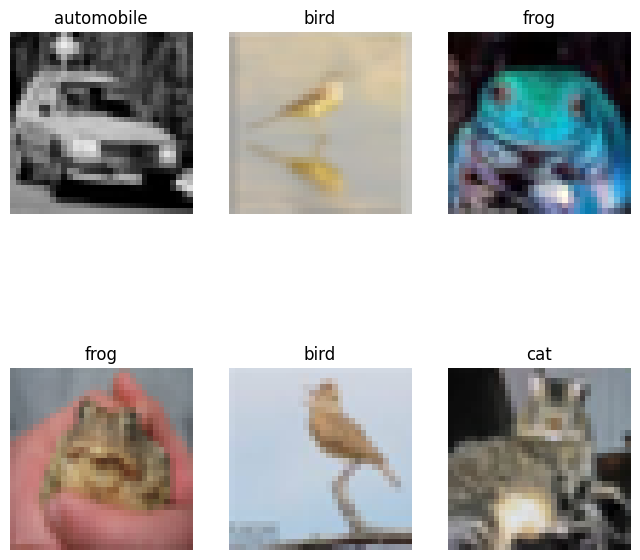

In [4]:
import matplotlib.pyplot as plt
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# class_names = np.array(class_names)[selected_classes]

# 可视化每个类别的一张图像
for i, (images, labels) in enumerate(trainloader):
    plt.figure(figsize=(8, 8))
    for j in range(6):  # 每个类别选择一张图片
        ax = plt.subplot(2, 3, j + 1)
        img = images[j].permute(1, 2, 0) * 0.5 + 0.5  # 去标准化
        plt.imshow(img)
        plt.title(class_names[labels[j]])
        plt.axis('off')
    break
plt.show()


# Custom CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 6)  # 输出6个类别

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Training

In [7]:
label2index = {label: i for i, label in enumerate(selected_classes)}
label2index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5}

In [15]:
import torch.optim as optim

# 初始化模型、损失函数和优化器
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, torch.tensor([label2index[label.item()] for label in labels]))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')


Epoch 1, Loss: 1.0573305018675099
Epoch 2, Loss: 0.7681718523949702
Epoch 3, Loss: 0.6562142074108124
Epoch 4, Loss: 0.5684428316697892
Epoch 5, Loss: 0.49225392499203874
Epoch 6, Loss: 0.42211282844228276
Epoch 7, Loss: 0.3476085310329252
Epoch 8, Loss: 0.28420298708590874
Epoch 9, Loss: 0.2259103815311562
Epoch 10, Loss: 0.16957948457743569


# Evaluation

In [17]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

# 模型评估函数
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    # 计算评估指标
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Accuracy: {acc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}')
    return cm

# 评估模型
cm = evaluate(model, testloader)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

# Results Visulization

In [19]:
import seaborn as sns

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'cm' is not defined

<Figure size 800x600 with 0 Axes>